In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import pytensor.tensor as pt

from scipy import stats
from scipy.optimize import curve_fit
import scipy.io as scio 

warnings.simplefilter(action="ignore", category=FutureWarning)

In [21]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95  # sets default credible interval used by arviz
np.random.seed(0)

In [3]:
data_file = r"D:\YuLab\Work\GPS\Data\Morad\GPS_07_Kornblum1000SRTSelf\GPSProgressClass_KornblumSRT_MORAD.csv"

In [4]:
d = pd.read_csv(data_file)
d.head()

,Subjects,SessionDate,Treatment,Dose,Label,SessionStartTime,Trials,TrialProgress,TrialStartTime,TrialStartTimeProgress,...,PortChosen,FP,RW,Outcome,ShuttleTime,HoldDuration,RT,MovementTime,ChoiceTime,Cued
0,Morad,20230903,NaN,0.0,NaN,11:55:29,1,1,4.7854,4.7854,...,NaN,1,0.5,Premature,2.0535,0.2894,NaN,NaN,NaN,1
1,Morad,20230903,NaN,0.0,NaN,11:55:29,2,2,18.6158,18.6158,...,2.0,1,0.5,Correct,1.6364,1.1266,0.1267,0.7291,0.8558,1
2,Morad,20230903,NaN,0.0,NaN,11:55:29,3,3,28.1459,28.1459,...,2.0,1,0.5,Correct,1.3158,1.1271,0.1272,0.5102,0.6374,1
3,Morad,20230903,NaN,0.0,NaN,11:55:29,4,4,38.6191,38.6191,...,2.0,1,0.5,Correct,1.4263,1.0655,0.0656,0.5790,0.6446,1
4,Morad,20230903,NaN,0.0,NaN,11:55:29,5,5,50.2572,50.2572,...,1.0,1,0.5,Correct,1.3846,1.0795,0.0796,0.4087,0.4883,1


In [5]:
d = d.loc[d["Cued"]==0, ["Label", "HoldDuration", "PortCorrect"]]
d.reset_index(inplace = True, drop = True)

In [7]:
d = d.loc[d["Label"].isin(["Control", "Chemo"])]
d.reset_index(inplace = True, drop = True)
d.head()

,Label,HoldDuration,PortCorrect
0,Control,1.1585,1
1,Control,1.0546,2
2,Control,1.0839,2
3,Control,1.1310,2
4,Control,1.1213,1


In [9]:
hold_duration = np.array(d["HoldDuration"])
treatment = np.array(d["Label"].isin(["Chemo"]).astype('int'))
port_correct = np.array(d["PortCorrect"])

num_trials = len(treatment)

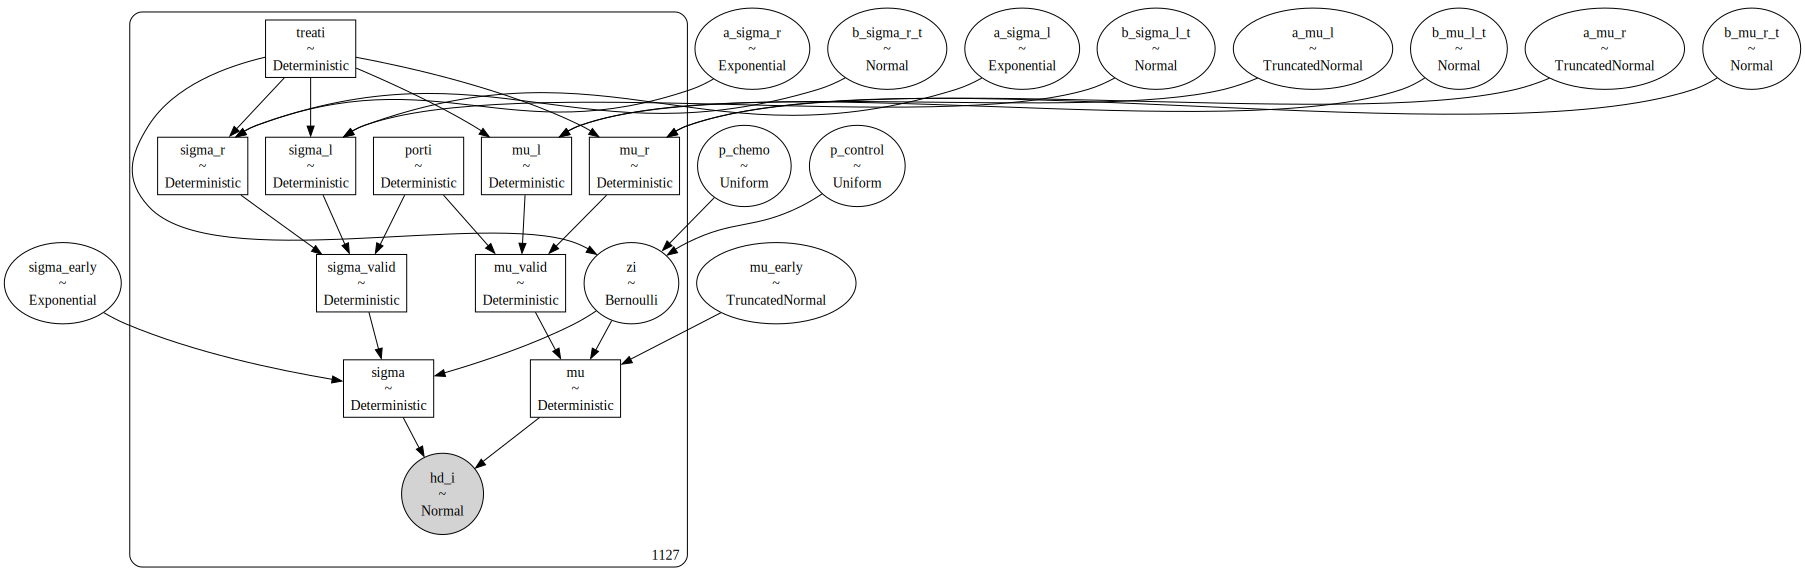

In [13]:
with pm.Model() as model_treatmeant:

    porti = pm.Deterministic("porti", pt.switch(pt.eq(port_correct, 1), 0, 1) ) # 0 - l; 1 - r
    treati = pm.Deterministic("treati", pt.switch(pt.eq(treatment, 0), 0, 1))

    # prior
    a_mu_l = pm.TruncatedNormal("a_mu_l", mu=1., sigma=0.5, lower=0.)
    a_mu_r = pm.TruncatedNormal("a_mu_r", mu=1., sigma=0.5, lower=0.)
    b_mu_l_t = pm.Normal("b_mu_l_t", mu=0., sigma=.5)
    b_mu_r_t = pm.Normal("b_mu_r_t", mu=0., sigma=.5)

    mu_l = pm.Deterministic("mu_l", a_mu_l + b_mu_l_t * treati)
    mu_r = pm.Deterministic("mu_r", a_mu_r + b_mu_r_t * treati)
    mu_valid = pm.Deterministic("mu_valid", (1-porti) * mu_l + porti * mu_r )

    a_sigma_l = pm.Exponential("a_sigma_l", lam=10.)
    a_sigma_r = pm.Exponential("a_sigma_r", lam=10.)
    b_sigma_l_t = pm.Normal("b_sigma_l_t", mu=0., sigma=.5)
    b_sigma_r_t = pm.Normal("b_sigma_r_t", mu=0., sigma=.5)

    sigma_l = pm.Deterministic("sigma_l", a_sigma_l + b_sigma_l_t * treati)
    sigma_r = pm.Deterministic("sigma_r", a_sigma_r + b_sigma_r_t * treati)
    sigma_valid = pm.Deterministic("sigma_valid", (1-porti) * sigma_l + porti * sigma_r )

    mu_early = pm.TruncatedNormal("mu_early", mu=0., sigma=0.2, lower=0., upper=.5)
    sigma_early = pm.Exponential("sigma_early", lam=10.)
    
    p_control = pm.Uniform("p_control", lower=0., upper=1.)
    p_chemo = pm.Uniform("p_chemo", lower=0., upper=1.)

    zi = pm.Bernoulli("zi", p=pt.switch(pt.eq(treati, 0), p_control, p_chemo), shape=num_trials) # Bernoulli(psi) is a weaker prior than Bernoulli(0.5)
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as
    mu = pm.Deterministic("mu", zi * mu_valid + (1 - zi) * mu_early)
    sigma = pm.Deterministic("sigma", zi * sigma_valid + (1 - zi) * sigma_early)

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)


In [22]:
with model_treatmeant:
    trace_treatment = pm.sample(chains=4, draws=1000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [a_mu_l, a_mu_r, b_mu_l_t, b_mu_r_t, a_sigma_l, a_sigma_r, b_sigma_l_t, b_sigma_r_t, mu_early, sigma_early, p_control, p_chemo]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 255 seconds.
c:\Users\ZhuohaoZhang\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [23]:
az.summary(trace_treatment, var_names=["a_mu_l", "a_mu_r", "b_mu_l_t", "b_mu_r_t", "a_sigma_l", "a_sigma_r", "b_sigma_l_t", "b_sigma_r_t", "mu_early", "sigma_early", "p_control", "p_chemo"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_mu_l,1.060,0.005,1.050,1.071,0.000,0.0,5921.0,3077.0,1.0
a_mu_r,1.056,0.006,1.045,1.068,0.000,0.0,4778.0,3197.0,1.0
b_mu_l_t,-0.021,0.036,-0.089,0.052,0.001,0.0,3061.0,2793.0,1.0
b_mu_r_t,0.057,0.017,0.025,0.090,0.000,0.0,5482.0,3076.0,1.0
a_sigma_l,0.091,0.004,0.084,0.099,0.000,0.0,5129.0,2746.0,1.0
a_sigma_r,0.099,0.005,0.091,0.109,0.000,0.0,2607.0,3255.0,1.0
b_sigma_l_t,0.348,0.026,0.294,0.397,0.001,0.0,2700.0,2806.0,1.0
b_sigma_r_t,0.105,0.012,0.080,0.128,0.000,0.0,4704.0,3190.0,1.0
mu_early,0.178,0.008,0.162,0.195,0.000,0.0,3758.0,3201.0,1.0
sigma_early,0.092,0.007,0.078,0.106,0.000,0.0,1966.0,2600.0,1.0


In [37]:
post_zi = trace_treatment.posterior["zi"].stack(sample=("chain", "draw")).values

In [41]:
params = ["a_mu_l", "a_mu_r", "b_mu_l_t", "b_mu_r_t", "a_sigma_l", "a_sigma_r", "b_sigma_l_t", "b_sigma_r_t", "mu_early", "sigma_early", "p_control", "p_chemo"]

post_sample = pd.DataFrame(columns=params)
for i in range(len(params)):
    post_sample[params[i]] = trace_treatment.posterior[params[i]].stack(sample=("chain", "draw")).values

scio.savemat(r"D:\YuLab\Work\GPS\Data\Morad\GPS_07_Kornblum1000SRTSelf\post_samples_model_treat.mat", {'post_sample_zi':post_zi, 'post_sample_param':post_sample, 'param_names':params})

In [19]:
with pm.Model() as model_1:

    # prior
    mu_control = pm.TruncatedNormal("mu_control", mu=1., sigma=0.5, lower=0.)
    mu_chemo = pm.TruncatedNormal("mu_chemo", mu=1., sigma=0.5, lower=0.)
    mu_early = pm.TruncatedNormal("mu_early", mu=0., sigma=0.2, lower=0., upper=.5)

    sigma_control = pm.Exponential("sigma_control", lam=10.)
    sigma_chemo = pm.Exponential("sigma_chemo", lam=10.)
    sigma_early = pm.Exponential("sigma_early", lam=10.)

    mu_valid = pm.Deterministic("mu_valid", pt.switch(pt.eq(ti, 0), mu_control, mu_chemo))
    sigma_valid = pm.Deterministic("sigma_valid", pt.switch(pt.eq(ti, 0), sigma_control, sigma_chemo))

    p_control = pm.Uniform("p_control", lower=0., upper=1.)
    p_chemo = pm.Uniform("p_chemo", lower=0., upper=1.)

    zi = pm.Bernoulli("zi", p=pt.switch(pt.eq(ti, 0), p_control, p_chemo), shape=num_trials) # Bernoulli(psi) is a weaker prior than Bernoulli(0.5)
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as
    mu = pm.Deterministic("mu", zi * mu_valid + (1 - zi) * mu_early)
    sigma = pm.Deterministic("sigma", zi * sigma_valid + (1 - zi) * sigma_early)

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)


In [20]:
with model_1:
    trace_1 = pm.sample(chains=4, draws=2000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_control, mu_chemo, mu_early, sigma_control, sigma_chemo, sigma_early, p_control, p_chemo]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 332 seconds.
c:\Users\ZhuohaoZhang\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [21]:
az.summary(trace_1, var_names=["mu_chemo", "mu_control", "mu_early", "sigma_chemo", "sigma_control", "sigma_early", "p_control", "p_chemo"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_chemo,1.085,0.019,1.055,1.115,0.0,0.0,6372.0,5755.0,1.0
mu_control,1.058,0.004,1.052,1.064,0.0,0.0,8567.0,6090.0,1.0
mu_early,0.177,0.008,0.164,0.190,0.0,0.0,6729.0,5964.0,1.0
sigma_chemo,0.331,0.014,0.308,0.352,0.0,0.0,5697.0,5581.0,1.0
sigma_control,0.095,0.003,0.090,0.099,0.0,0.0,5540.0,5899.0,1.0
sigma_early,0.093,0.007,0.081,0.104,0.0,0.0,3655.0,6022.0,1.0
p_control,0.972,0.007,0.962,0.982,0.0,0.0,8336.0,6152.0,1.0
p_chemo,0.734,0.021,0.700,0.766,0.0,0.0,7486.0,5950.0,1.0


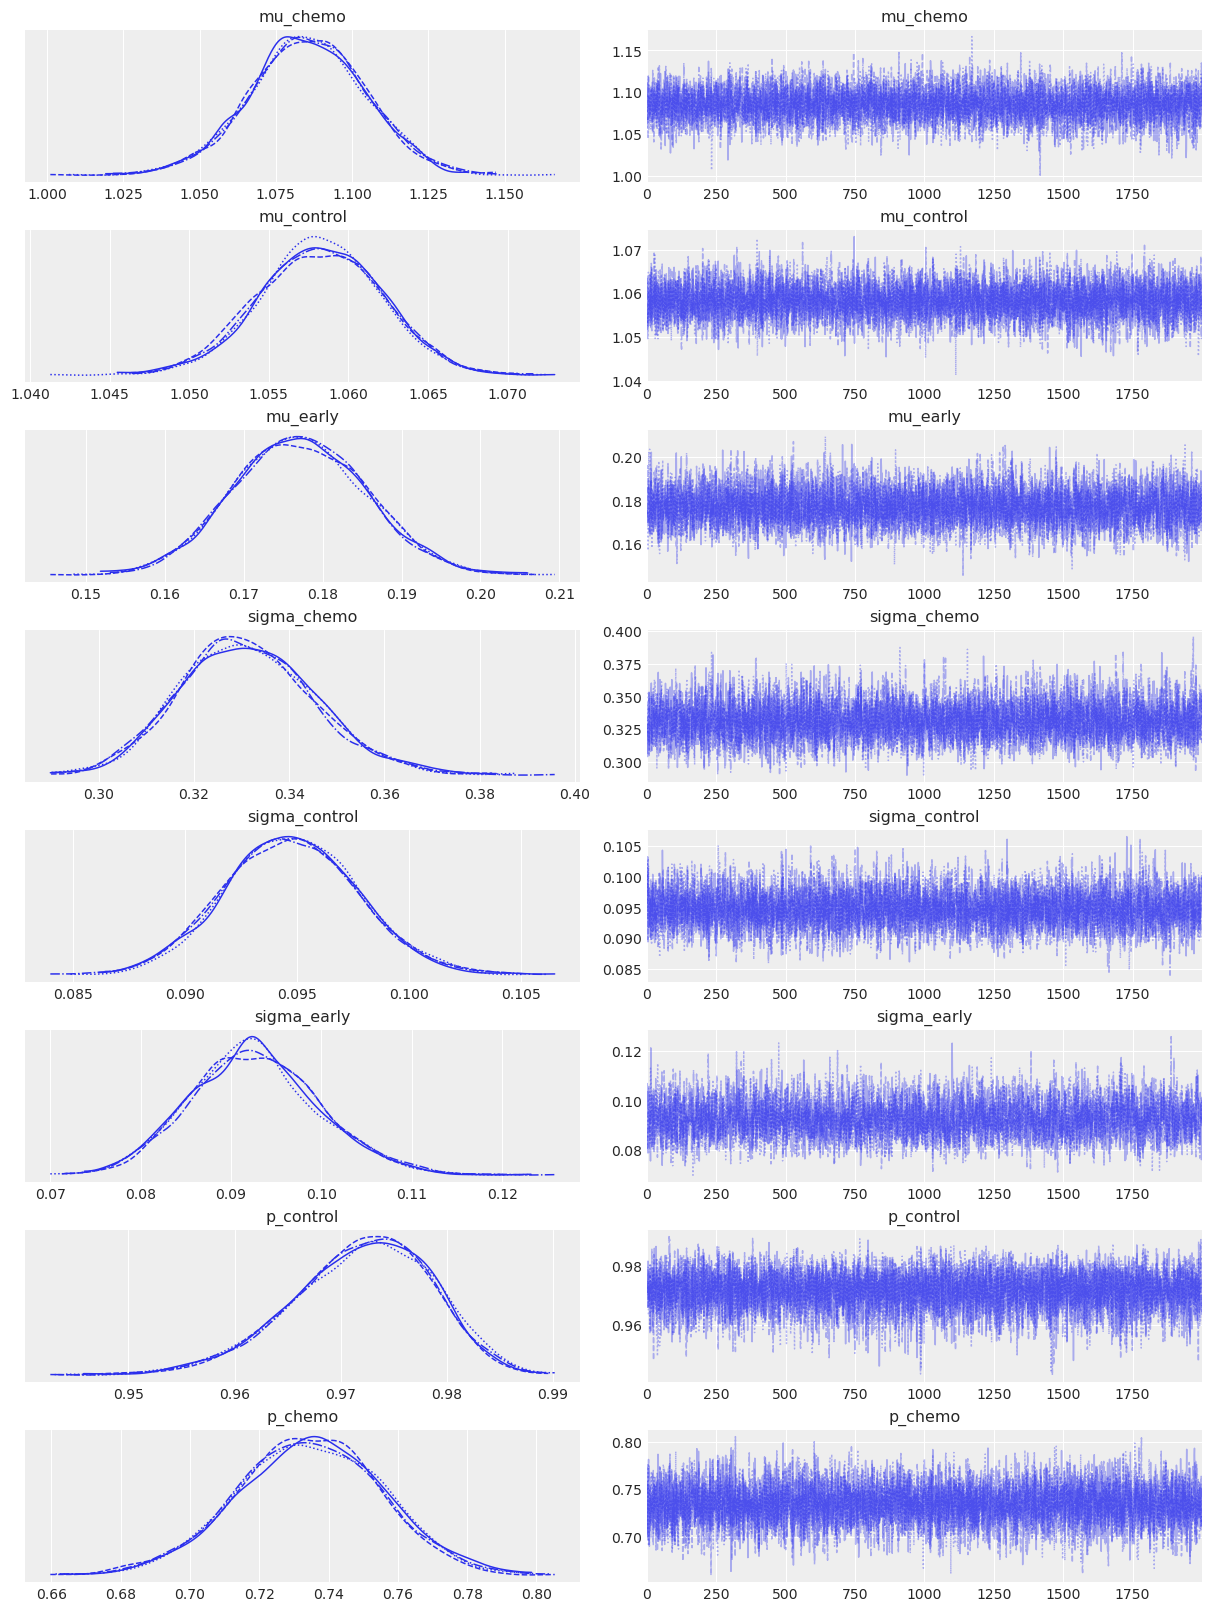

In [22]:
az.plot_trace(trace_1, var_names=["mu_chemo", "mu_control", "mu_early", "sigma_chemo", "sigma_control", "sigma_early", "p_control", "p_chemo"])
plt.show()

In [23]:
with pm.Model() as model_2:

    # prior
    #mu
    mu_control_l = pm.TruncatedNormal("mu_control_l", mu=1., sigma=0.5, lower=0.)
    mu_control_r = pm.TruncatedNormal("mu_control_r", mu=1., sigma=0.5, lower=0.)
    
    mu_chemo_l = pm.TruncatedNormal("mu_chemo_l", mu=1., sigma=0.5, lower=0.)
    mu_chemo_r = pm.TruncatedNormal("mu_chemo_r", mu=1., sigma=0.5, lower=0.)

    mu_early = pm.TruncatedNormal("mu_early", mu=0., sigma=0.2, lower=0., upper=.5)

    # sigma
    sigma_control_l = pm.Exponential("sigma_control_l", lam=10.)
    sigma_control_r = pm.Exponential("sigma_control_r", lam=10.)
    
    sigma_chemo_l = pm.Exponential("sigma_chemo_l", lam=10.)
    sigma_chemo_r = pm.Exponential("sigma_chemo_r", lam=10.)
    
    sigma_early = pm.Exponential("sigma_early", lam=10.)

    # trial condition
    pi = pm.Deterministic("pi", pt.switch(pt.eq(port_correct, 1), 0, 1) ) # 0 - l; 1 - r
    ti = pm.Deterministic("ti", pt.switch(pt.eq(treatment, 0), 0, 1))
    
    mu_valid = pm.Deterministic("mu_valid", (1-ti) * pi * mu_control_l + (1-ti) * (1-pi) * mu_control_r + ti * pi * mu_chemo_l + ti * (1-pi) * mu_chemo_r )
    sigma_valid = pm.Deterministic("sigma_valid", (1-ti) * pi * sigma_control_l + (1-ti) * (1-pi) * sigma_control_r + ti * pi * sigma_chemo_l + ti * (1-pi) * sigma_chemo_r )

    # initialize failure
    p_control = pm.Uniform("p_control", lower=0., upper=1.)
    p_chemo = pm.Uniform("p_chemo", lower=0., upper=1.)

    zi = pm.Bernoulli("zi", p=pt.switch(pt.eq(ti, 0), p_control, p_chemo), shape=num_trials) # Bernoulli(psi) is a weaker prior than Bernoulli(0.5)
    
    # mum and mub were meant to be 1-mum and 1-mub in the original PyMC3 codes
    # mum = pm.Deterministic("mum", 1 / (1 + pt.exp(pt.log(1 / mub - 1) + mud)))
    # Following the code in the book, mum is defined as
    mu = pm.Deterministic("mu", zi * mu_valid + (1 - zi) * mu_early)
    sigma = pm.Deterministic("sigma", zi * sigma_valid + (1 - zi) * sigma_early)

    # observed
    hd_i = pm.Normal("hd_i", mu=mu, sigma=sigma, observed=hold_duration)

In [24]:
with model_2:
    trace_2 = pm.sample(chains=4, draws=2000, tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_control_l, mu_control_r, mu_chemo_l, mu_chemo_r, mu_early, sigma_control_l, sigma_control_r, sigma_chemo_l, sigma_chemo_r, sigma_early, p_control, p_chemo]
>BinaryGibbsMetropolis: [zi]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 380 seconds.
c:\Users\ZhuohaoZhang\anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [25]:
az.summary(trace_2, var_names=["mu_chemo_l", "mu_control_l", "mu_chemo_r", "mu_control_r", "mu_early", "sigma_chemo_l", "sigma_control_l", "sigma_chemo_r", "sigma_control_r", "sigma_early", "p_control", "p_chemo"])

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_chemo_l,1.114,0.015,1.089,1.138,0.0,0.0,11334.0,6602.0,1.0
mu_control_l,1.056,0.006,1.047,1.065,0.0,0.0,11870.0,5984.0,1.0
mu_chemo_r,1.041,0.035,0.987,1.097,0.0,0.0,6981.0,5777.0,1.0
mu_control_r,1.060,0.005,1.052,1.068,0.0,0.0,11897.0,5715.0,1.0
mu_early,0.177,0.008,0.164,0.191,0.0,0.0,8198.0,6341.0,1.0
sigma_chemo_l,0.203,0.011,0.185,0.221,0.0,0.0,10370.0,6771.0,1.0
sigma_control_l,0.099,0.005,0.092,0.107,0.0,0.0,5583.0,6325.0,1.0
sigma_chemo_r,0.432,0.025,0.389,0.468,0.0,0.0,6313.0,6065.0,1.0
sigma_control_r,0.091,0.004,0.085,0.097,0.0,0.0,11742.0,6128.0,1.0
sigma_early,0.092,0.007,0.081,0.103,0.0,0.0,3924.0,5202.0,1.0


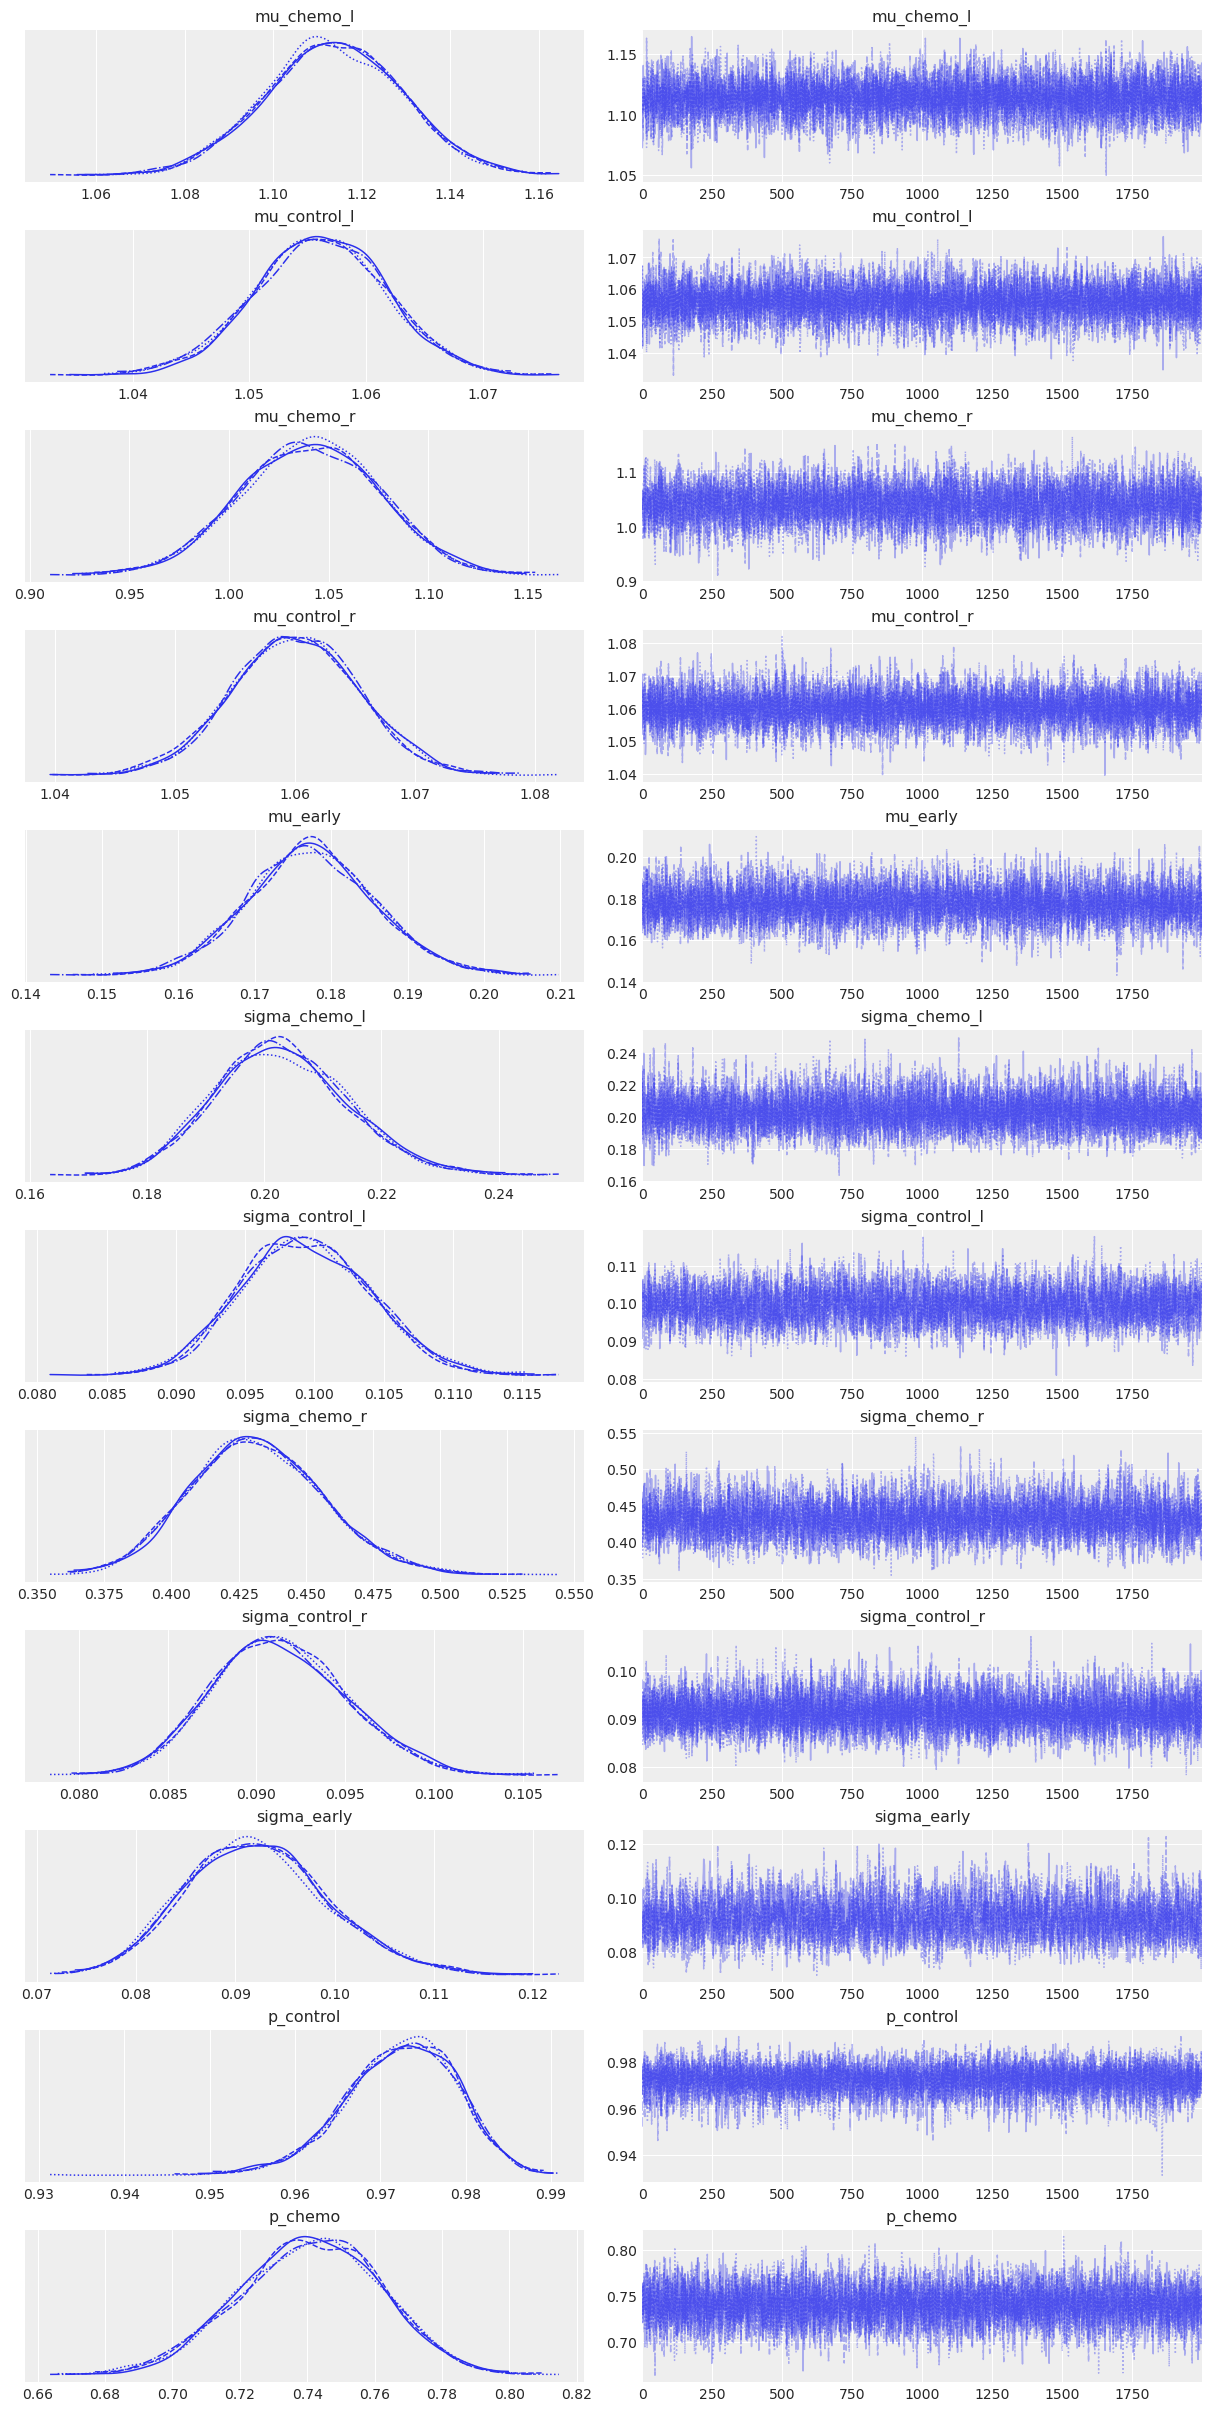

In [26]:
az.plot_trace(trace_2, var_names=["mu_chemo_l", "mu_control_l", "mu_chemo_r", "mu_control_r", "mu_early", "sigma_chemo_l", "sigma_control_l", "sigma_chemo_r", "sigma_control_r", "sigma_early", "p_control", "p_chemo"])

plt.show()